In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.applications import  Xception
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_dir = r'C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\uygulamali_sinir_proje\real-vs-fake'

file_paths = []
labels = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.jpg'):
            file_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

data_df = pd.DataFrame({'filepaths': file_paths, 'labels': labels})
print(data_df.head())
print(data_df.tail())

                                           filepaths labels
0  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
1  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
2  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
3  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
4  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   fake
                                                filepaths labels
144851  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real
144852  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real
144853  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real
144854  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real
144855  C:\Users\Metehan Sevgil\Desktop\KODLAR\Phyton\...   real


In [4]:
max_epoch = 50
batch_size = 32
img_size = (128, 128)

data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = data_gen.flow_from_directory("./real-vs-fake/train",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical')

test_gen = data_gen.flow_from_directory("./real-vs-fake/test",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical')

val_gen = data_gen.flow_from_directory("./real-vs-fake/val",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical')

Found 103236 images belonging to 2 classes.
Found 23240 images belonging to 2 classes.
Found 23236 images belonging to 2 classes.


In [5]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = True

model = Sequential()
model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())


model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [6]:
model_checkpoint = ModelCheckpoint('best_model_xception.h5', monitor='val_loss', save_best_only=True,)

In [7]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=max_epoch,
                    callbacks=[model_checkpoint])

Epoch 1/50
3227/3227 [==============================] - 849s 260ms/step - loss: 0.2291 - accuracy: 0.9022 - val_loss: 0.2638 - val_accuracy: 0.8832
Epoch 2/50
3227/3227 [==============================] - 865s 268ms/step - loss: 0.0715 - accuracy: 0.9753 - val_loss: 0.0673 - val_accuracy: 0.9738
Epoch 3/50
3227/3227 [==============================] - 857s 266ms/step - loss: 0.0474 - accuracy: 0.9842 - val_loss: 0.0439 - val_accuracy: 0.9858
Epoch 4/50
3227/3227 [==============================] - 854s 265ms/step - loss: 0.0333 - accuracy: 0.9892 - val_loss: 0.2001 - val_accuracy: 0.9272
Epoch 5/50
3227/3227 [==============================] - 853s 264ms/step - loss: 0.0263 - accuracy: 0.9914 - val_loss: 0.0360 - val_accuracy: 0.9879
Epoch 6/50
3227/3227 [==============================] - 848s 263ms/step - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.0487 - val_accuracy: 0.9814
Epoch 7/50
3227/3227 [==============================] - 845s 262ms/step - loss: 0.0203 - accuracy: 0.9933 - val_

In [18]:
val_losses = history.history['val_loss']
val_acc = history.history['val_accuracy']
min_val_loss = min(val_losses)
best_epoch = val_losses.index(min_val_loss) + 1

print(f"Val_loss değeri: {min_val_loss:.4f}")
print(f"Bu değer {best_epoch}. epoch'ta elde edildi.")

Val_loss değeri: 0.0134
Bu değer 35. epoch'ta elde edildi.


In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nModelin Test Seti Üzerindeki Performansı:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

727/727 [==============================] - 53s 73ms/step - loss: 0.0334 - accuracy: 0.9923

Modelin Test Seti Üzerindeki Performansı:
Test Accuracy: 0.9923
Test Loss: 0.0334


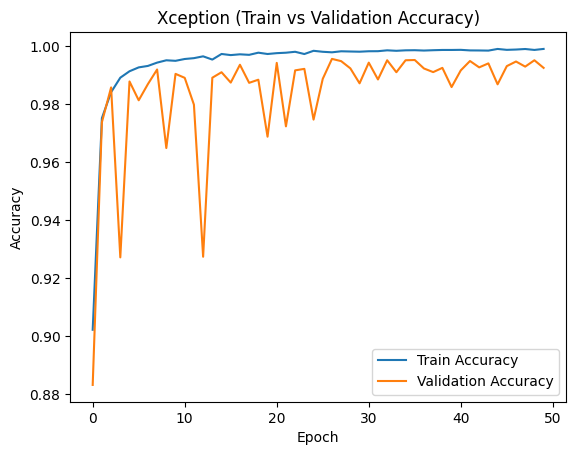

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Xception (Train vs Validation Accuracy)")
plt.legend()
plt.show()


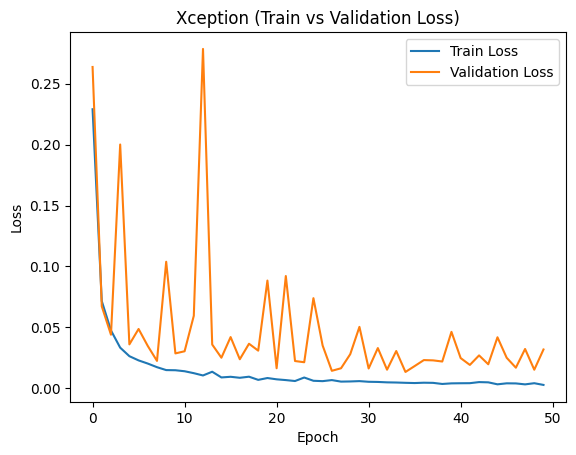

In [11]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Xception (Train vs Validation Loss)")
plt.show()

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
y_true = []
y_pred_probs = []

for i in range(len(test_gen)):
    img_batch, label_batch = next(test_gen)
    y_true.extend(np.argmax(label_batch, axis=1)) 
    preds = model.predict(img_batch)  
    y_pred_probs.extend(preds)

1/1 [==============================] - 1s 708ms/step


In [14]:
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)

In [15]:
report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys(), digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        fake     0.9989    0.9857    0.9922     11620
        real     0.9859    0.9989    0.9923     11620

    accuracy                         0.9923     23240
   macro avg     0.9924    0.9923    0.9923     23240
weighted avg     0.9924    0.9923    0.9923     23240



In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred, average="weighted")
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_true, y_pred, average="weighted")
print(f"F1-score: {f1:.4f}")

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.9924
Recall: 0.9923
F1-score: 0.9923
Accuracy: 0.9923


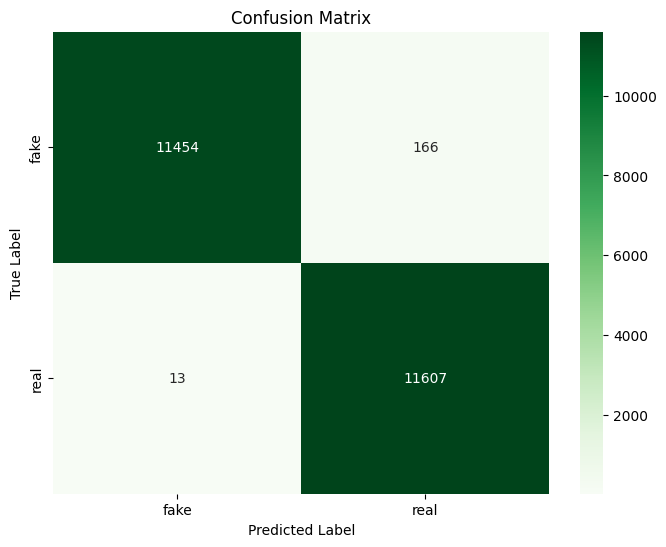

In [17]:
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()